In [2]:
# 📦 Kirjastot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# 📁 Datan luku
apukka_df = pd.read_csv("Rovaniemi_Apukka_lampotila.csv", sep=",")
rautatieasema_df = pd.read_csv("Rovaniemi_rautatieasema_lampotila.csv", sep=",")


In [4]:
# 🧼 Siivous ja päivämäärän luonti
for df in [apukka_df, rautatieasema_df]:
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df.rename(columns={"Vuosi": "year", "Kuukausi": "month", "Päivä": "day"}, inplace=True)
    df["Pvm"] = pd.to_datetime(df[["year", "month", "day"]])
    for col in ["Lumensyvyys [cm]", "Sademäärä [mm]", "Ilman keskilämpötila [°C]"]:
        df[col] = pd.to_numeric(df[col].replace("-", pd.NA), errors='coerce')

# ✅ Valitaan tarvittavat sarakkeet
apukka = apukka_df[["Pvm", "Lumensyvyys [cm]", "Sademäärä [mm]", "Ilman keskilämpötila [°C]"]].copy()
rautatie = rautatieasema_df[["Pvm", "Lumensyvyys [cm]", "Sademäärä [mm]", "Ilman keskilämpötila [°C]"]].copy()

apukka.columns = ["Pvm", "Lumensyvyys_Apukka", "Sade_Apukka", "Lampotila_Apukka"]
rautatie.columns = ["Pvm", "Lumensyvyys_Rautatie", "Sade_Rautatie", "Lampotila_Rautatie"]

In [5]:
# 🔗 Yhdistetään datat
df = pd.merge(apukka, rautatie, on="Pvm", how="inner")
df["Lumensyvyys_keskiarvo"] = df[["Lumensyvyys_Apukka", "Lumensyvyys_Rautatie"]].mean(axis=1)
df["Sade_keskiarvo"] = df[["Sade_Apukka", "Sade_Rautatie"]].mean(axis=1)
df["Lampotila_keskiarvo"] = df[["Lampotila_Apukka", "Lampotila_Rautatie"]].mean(axis=1)
df = df.sort_values("Pvm").reset_index(drop=True)

In [6]:
# 🎯 Kohdemuuttujan luonti
df["snow_today"] = df["Lumensyvyys_keskiarvo"]
df["snow_tomorrow"] = df["snow_today"].shift(-1)
df["target"] = (df["snow_tomorrow"] < df["snow_today"]).astype(int)
final_df = df[(df["snow_today"] > 0) & (~df["snow_today"].isna())].copy()

In [7]:
# 🎓 Mallin opetus
features = ["Lampotila_keskiarvo", "Sade_keskiarvo", "snow_today"]
X = final_df[features]
y = final_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [8]:
# 🧾 Arviointi
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test, y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74       109
           1       0.66      0.65      0.65        85

    accuracy                           0.70       194
   macro avg       0.70      0.70      0.70       194
weighted avg       0.70      0.70      0.70       194



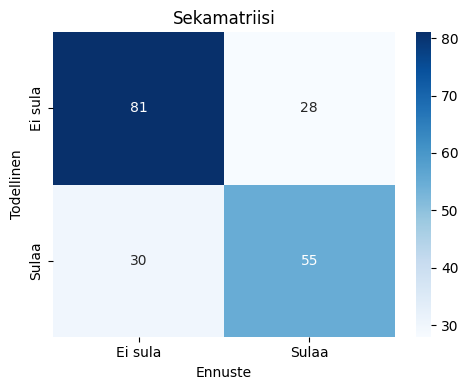

In [9]:
# 🔥 Sekamatriisi
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Ei sula", "Sulaa"], yticklabels=["Ei sula", "Sulaa"])
plt.xlabel("Ennuste")
plt.ylabel("Todellinen")
plt.title("Sekamatriisi")
plt.tight_layout()
plt.show()

In [10]:
# 📈 Tärkeimmät piirteet
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importances:\n", importances)


Feature Importances:
 Lampotila_keskiarvo    0.574417
snow_today             0.276000
Sade_keskiarvo         0.149583
dtype: float64
